In [729]:
import tensorflow as tf
import numpy as np # for numerical operations and linear algebra
import matplotlib.pyplot as plt
import pandas as pd
import os
from PIL import Image
from typing import Tuple
from tqdm import tqdm


image_dir = "C:/Users/austi/Downloads/datasetImages_warp256/"
label_csv_path = "C:/Users/austi/Downloads/"


batch_size = 32
epochs = 50




In [730]:
toPILImage = lambda x: tf.keras.preprocessing.image.array_to_img(x)

In [731]:
class AADB(tf.keras.utils.Sequence):
    attributes = [
        "balancing_elements",
        "color_harmony",
        "content",
        "depth_of_field",
        "light",
        "motion_blur",
        "object",
        "repetition",
        "rule_of_thirds",
        "symmetry",
        "vivid_color",
        "score",
    ]

    def preprocess_image(self, image):
        image = tf.image.resize(image, [256, 256])
        image = tf.cast(image, tf.float32) / 127.5 - 1
        return image

    def __init__(self, image_dir, label_csv_path, batch_size=32, test=False):
        self.label_csv_path = label_csv_path
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.test = test


        self.files, self.labels = self.load_data(self.image_dir, self.label_csv_path, self.test)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        image = Image.open(self.files[index]).convert('RGB')
        image = self.preprocess_image(image)
        assert image.shape == (256, 256, 3)
        label = tf.convert_to_tensor(self.labels[index], dtype=tf.float32)
        return image, label


    def load_data(self, image_dir, csv_path, test=False):
        csv_file = csv_path + 'Dataset.csv' if not test else csv_path + 'Dataset_test.csv'
        label_csv = pd.read_csv(csv_file, delimiter=",")
        files = [os.path.join(image_dir, f) for f in label_csv['ImageFile']]
        #labels = label_csv.drop(['ImageFile'], axis=1).values
        labels = []
        for index, label in label_csv.drop(['ImageFile'], axis=1).iterrows():  # this is for moving score to the last value
            label = list(label.values)
            label.append(label.pop(9))
            labels.append(label)

        # Moving 'score' to the last column
        labels = np.asarray(labels)
        return files, labels

    def load_and_preprocess_image(self, file):
        image = tf.io.read_file(file)
        image = tf.image.decode_jpeg(image, channels=3)
        image = self.transform(image)
        return image

In [732]:
aadb = AADB(image_dir, label_csv_path)

In [733]:
def show_example(img, label):
    print(label)
    plt.imshow(toPILImage(img))
    plt.show()

In [734]:
def show_batch(dataset):
    for images, labels in dataset.take(1):
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([])
        ax.set_yticks([])
        images = tf.concat(tf.unstack(images, axis=0), axis=1)  # Concatenate images horizontally
        ax.imshow(images)
        break

tf.Tensor([-0.2  0.2 -0.2 -0.4  0.   0.  -0.4  0.  -0.2  0.   0.3  0. ], shape=(12,), dtype=float32)


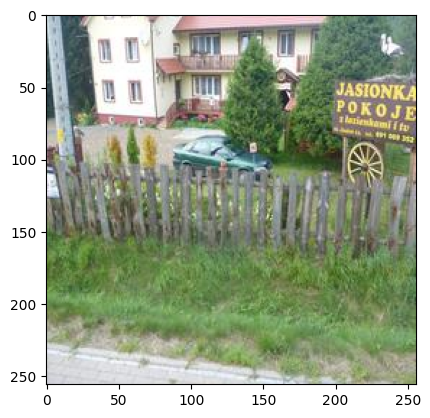

8958

In [735]:
show_example(*aadb[0])
len(aadb)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


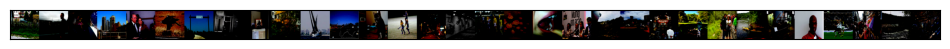

In [736]:


#train_ds, val_ds = random_split(aadb, [train_size, val_size])
#train_ds, val_ds = tf.data.Dataset.from_tensor_slices(aadb.files[:train_size]), tf.data.Dataset.from_tensor_slices(aadb.files[train_size:])
val_size = 500
train_size = len(aadb.files) - val_size

train_ds = tf.data.Dataset.from_generator(
    lambda: aadb,
    output_types=(tf.float32, tf.float32),
    output_shapes=((256, 256, 3), (12,))
).take(train_size)

val_ds = tf.data.Dataset.from_generator(
    lambda: aadb,
    output_types=(tf.float32, tf.float32),
    output_shapes=((256, 256, 3), (12,))
).skip(train_size)

train_ds = train_ds.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
val_ds = val_ds.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

show_batch(train_ds)



In [737]:
class RankLoss(tf.keras.losses.Loss):

    def __init__(self, margin):
        super().__init__()
        self.margin = margin

    def call(self, y_true, y_pred):
        # Calculate target
        target = tf.ones_like(y_true[0], dtype=y_pred[0].dtype)

        # Set indices where y_true1 < y_true2 to -1
        target = tf.where(y_true[0] < y_true[1], -1.0 * tf.ones_like(target), target)

        # Calculate margin ranking loss
        loss = tf.maximum(0.0, self.margin - (y_pred[0] - y_pred[1]) * target)
        return tf.reduce_mean(loss)




class RegRankLoss(tf.Module):

    def __init__(self, margin: float):
        super().__init__()
        self.reg_loss = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)
        self.rank_loss = RankLoss(margin)

    def __call__(self,
        y_pred: Tuple[tf.Tensor, tf.Tensor],
        y_true: Tuple[tf.Tensor, tf.Tensor]) -> Tuple[tf.Tensor, tf.Tensor]:
        
        loss_reg = (
            self.reg_loss(y_pred[0], y_true[0]) +
            self.reg_loss(y_pred[1], y_true[1])
        ) / 2.0

        loss_rank = self.rank_loss(y_pred, y_true)
        loss = loss_reg + loss_rank
        return loss, loss_reg, loss_rank
    
    

In [738]:
import tensorflow as tf

def create_backbone(backbone_name, pretrained=True):
    """
    Creates a backbone model from a pre-trained model.
    Args:
        backbone_name (str): Name of the backbone model (e.g., 'resnet50').
        pretrained (bool): Whether to use pre-trained weights.
    Returns:
        tf.keras.Model: The backbone model.
    """
    backbone = getattr(tf.keras.applications, backbone_name)(
        include_top=False,
        weights='imagenet' if pretrained else None,
        input_shape=(256, 256, 3)  # Replace with your input shape
    )
    backbone.trainable = False  # Freeze the backbone layers
    return backbone

    
def create_regression_network(backbone, num_attributes):
    """
    Creates a regression network using the given backbone.
    Args:
        backbone (tf.keras.Model): The backbone model.
        num_attributes (int): Number of attributes for the regression task.
    Returns:
        tf.keras.Model: The regression network.
    """
    inputs = backbone.input
    x = backbone.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    outputs = tf.keras.layers.Dense(num_attributes)(x)
    model = tf.keras.Model(inputs, outputs)
    return model


In [739]:

#model = RegressionNetwork(backbone='ResNet50', num_attributes=len(attributes), pretrained=False)
model = create_regression_network(create_backbone('ResNet50', pretrained=False), 12)


In [740]:
loss_fn = RegRankLoss(margin=0.02)

In [741]:

optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9)

train_losses = []
train_losses_reg = []
train_losses_rank = []
val_losses = []

pbar = tqdm(enumerate(train_ds), total=train_size // batch_size)
for batch, (x, y) in pbar:
    with tf.GradientTape() as tape:
        y_pred = model(x, training=True)
        print(y_pred.shape, y.shape)
        loss, loss_reg, loss_rank = loss_fn(y_pred, y)
    

  0%|          | 0/264 [00:00<?, ?it/s]

  0%|          | 1/264 [00:01<08:25,  1.92s/it]

(32, 12) (32, 12)


  1%|          | 2/264 [00:03<08:06,  1.86s/it]

(32, 12) (32, 12)


  1%|          | 3/264 [00:05<07:55,  1.82s/it]

(32, 12) (32, 12)


  2%|▏         | 4/264 [00:07<07:46,  1.80s/it]

(32, 12) (32, 12)


  2%|▏         | 5/264 [00:09<07:44,  1.79s/it]

(32, 12) (32, 12)


  2%|▏         | 6/264 [00:10<07:39,  1.78s/it]

(32, 12) (32, 12)


  3%|▎         | 7/264 [00:12<07:48,  1.82s/it]

(32, 12) (32, 12)


  3%|▎         | 8/264 [00:14<07:58,  1.87s/it]

(32, 12) (32, 12)


  3%|▎         | 9/264 [00:16<08:01,  1.89s/it]

(32, 12) (32, 12)


  4%|▍         | 10/264 [00:18<08:06,  1.91s/it]

(32, 12) (32, 12)


  4%|▍         | 11/264 [00:20<08:07,  1.93s/it]

(32, 12) (32, 12)


  5%|▍         | 12/264 [00:22<08:05,  1.93s/it]

(32, 12) (32, 12)


  5%|▍         | 13/264 [00:24<08:05,  1.94s/it]

(32, 12) (32, 12)


  5%|▌         | 14/264 [00:26<08:06,  1.95s/it]

(32, 12) (32, 12)


  6%|▌         | 15/264 [00:28<08:05,  1.95s/it]

(32, 12) (32, 12)


  6%|▌         | 16/264 [00:30<08:04,  1.95s/it]

(32, 12) (32, 12)


  6%|▋         | 17/264 [00:32<08:05,  1.97s/it]

(32, 12) (32, 12)


  7%|▋         | 18/264 [00:34<08:06,  1.98s/it]

(32, 12) (32, 12)


  7%|▋         | 18/264 [00:36<08:12,  2.00s/it]


KeyboardInterrupt: 